# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix

# Load Dataset

In [ ]:
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")
print("Path to dataset files:", path)

books = pd.read_csv(f"{path}/Books.csv", encoding='utf-8')
users = pd.read_csv(f"{path}/Users.csv", encoding='utf-8')
ratings = pd.read_csv(f"{path}/Ratings.csv", encoding='utf-8')
print(f"Books shape: {books.shape}")
print(f"Users shape: {users.shape}")
print(f"Ratings shape: {ratings.shape}")

Path to dataset files: /kaggle/input/book-recommendation-dataset
Books shape: (271360, 8)
Users shape: (278858, 3)
Ratings shape: (1149780, 3)


# Data Understanding

Pada bagian ini, kita melakukan eksplorasi awal pada dataset untuk memahami struktur, konten, dan properti statistiknya. Ini termasuk memeriksa tipe data, melihat ringkasan statistik, mengidentifikasi nilai yang hilang (missing values).

In [ ]:
print("\nBOOKS DATASET OVERVIEW:")
print("-" * 30)
print(books.head())
print(f"\nDataset Info:")
print(f"Shape: {books.shape}")
print(f"Columns: {list(books.columns)}")

print(f"\nData Types:")
print(books.dtypes)

print(f"\nMissing Values:")
missing_books = books.isnull().sum()
print(missing_books[missing_books > 0])

print(f"\nBOOKS DATASET STATISTICS:")
print("-" * 30)
print(books.describe(include='all'))

print(f"\nRATINGS DISTRIBUTION:")
print("-" * 25)
print(ratings['Book-Rating'].value_counts().sort_index())

print(f"\nDuplicate Rows in Books Dataset:")
duplicates = books.duplicated()
print(f"Total duplicated rows: {duplicates.sum()}")

if duplicates.any():
    print(books[duplicates].head())



BOOKS DATASET OVERVIEW:
------------------------------
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/

# Outlier pada data

In [ ]:
def detect_outliers_iqr(df, iqr_multiplier=1.5, verbose=True, show_rows=False):
    outlier_dict = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if not outliers.empty:
            outlier_dict[col] = outliers
            if verbose:
                print(f"\n📌 Kolom '{col}' memiliki {len(outliers)} outlier.")
            if show_rows:
                print(outliers[[col]].sort_values(by=col).head(10))

    if not outlier_dict and verbose:
        print("✅ Tidak ditemukan outlier dalam kolom numerik.")

    return outlier_dict


outliers_users = detect_outliers_iqr(users)
book_ratings = ratings.groupby('ISBN').agg({
    'Book-Rating': ['count', 'mean']
}).reset_index()
book_ratings.columns = ['ISBN', 'rating_count', 'avg_rating']

outliers_ratings = detect_outliers_iqr(book_ratings)




📌 Kolom 'Age' memiliki 1084 outlier.

📌 Kolom 'rating_count' memiliki 57871 outlier.


# Data Visualization

memvisualisasikan beberapa aspek kunci dari data untuk mendapatkan distribusi rating buku, top 10 penerbit, distribusi tahun penerbit, dan top 10 penulis.

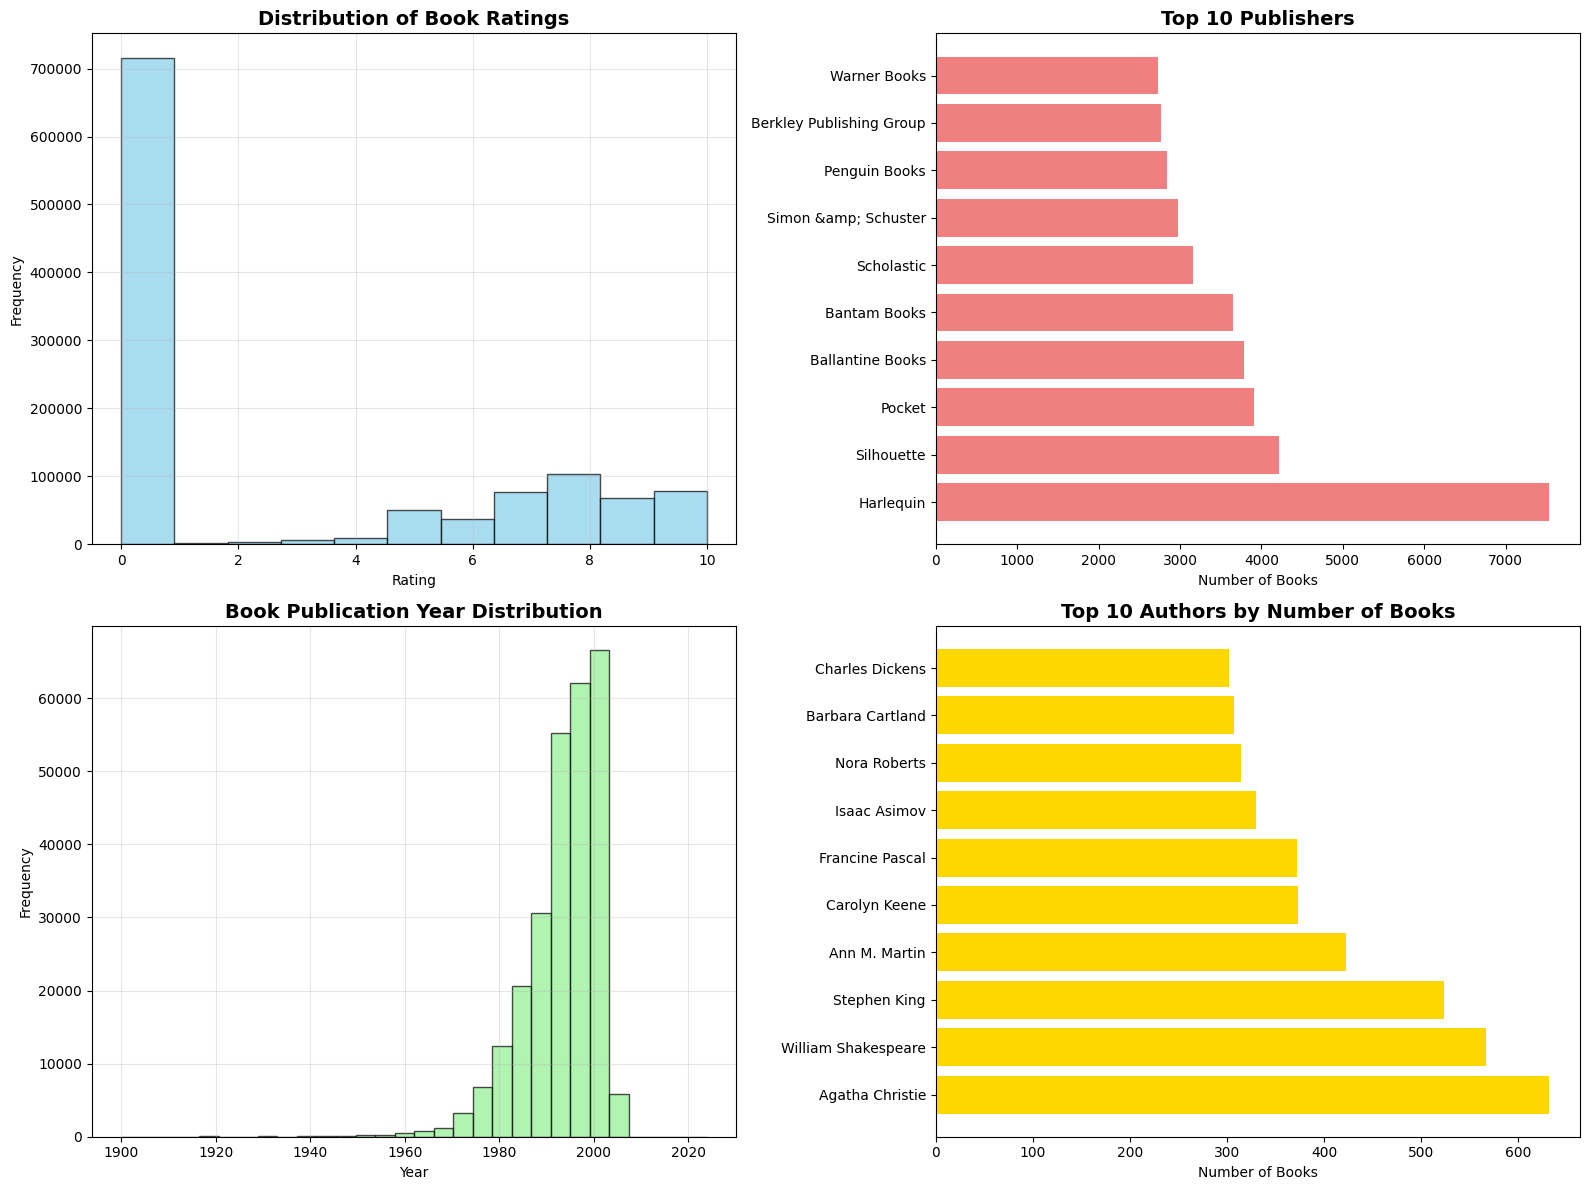

In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# 1. Rating distribution
axes[0,0].hist(ratings['Book-Rating'], bins=11, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Book Ratings', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# 2. Top publishers
top_publishers = books['Publisher'].value_counts().head(10)
axes[0,1].barh(range(len(top_publishers)), top_publishers.values, color='lightcoral')
axes[0,1].set_yticks(range(len(top_publishers)))
axes[0,1].set_yticklabels([pub[:25] + '...' if len(str(pub)) > 25 else str(pub) for pub in top_publishers.index])
axes[0,1].set_title('Top 10 Publishers', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Number of Books')

# 3. Publication year distribution
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
valid_years = books[(books['Year-Of-Publication'] >= 1900) & (books['Year-Of-Publication'] <= 2024)]['Year-Of-Publication']
axes[1,0].hist(valid_years, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1,0].set_title('Book Publication Year Distribution', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)

# 4. Top authors
top_authors = books['Book-Author'].value_counts().head(10)
axes[1,1].barh(range(len(top_authors)), top_authors.values, color='gold')
axes[1,1].set_yticks(range(len(top_authors)))
axes[1,1].set_yticklabels([author[:20] + '...' if len(str(author)) > 20 else str(author) for author in top_authors.index])
axes[1,1].set_title('Top 10 Authors by Number of Books', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Number of Books')

plt.tight_layout()
plt.show()

## Data Preparation

Tahapan persiapan data dilakukan untuk memastikan data yang digunakan oleh model berkualitas, relevan, dan bebas dari noise. Berikut adalah langkah-langkah yang dilakukan:

- Penanganan Nilai yang Hilang (Missing Values):

    Kolom Book-Author dan Publisher yang kosong diisi dengan string 'Unknown'.
    Alasan: Menghindari error pada saat pemrosesan teks dan memastikan semua baris data dapat digunakan. Menggantinya dengan 'Unknown' lebih baik daripada menghapus baris karena masih ada informasi lain yang berharga.

- Pembersihan dan Validasi Data:

    Kolom Year-Of-Publication dikonversi menjadi tipe numerik dan divalidasi agar hanya berisi tahun yang masuk akal (antara 1900-2024).
    Alasan: Data tahun terbit memiliki beberapa nilai yang tidak valid (misalnya, teks atau angka 0). Validasi ini penting untuk memastikan fitur decade yang akan dibuat akurat.

- Penggabungan dan Agregasi Data:

    Dataset books dan ratings digabungkan untuk menghitung jumlah rating (rating_count) dan rata-rata rating (avg_rating) untuk setiap buku.
    Alasan: Informasi ini penting untuk memfilter buku mana yang cukup populer untuk dimasukkan ke dalam model, sehingga rekomendasi yang dihasilkan lebih andal.

- Filtering Data untuk Mengurangi Noise:

    Hanya buku dengan jumlah rating 20 atau lebih (rating_count >= 20) yang dipertahankan.
    Alasan: Ini adalah langkah krusial untuk mengurangi sparsity dan memastikan model hanya belajar dari buku-buku yang memiliki cukup data interaksi. Rekomendasi untuk buku yang hanya memiliki 1-2 rating cenderung tidak akurat.

- Feature Engineering:

    Sebuah fitur baru bernama content_features dibuat dengan menggabungkan teks dari Book-Author, Publisher, dan decade.
    Alasan: Fitur ini menjadi "DNA" konten dari setiap buku. Dengan mengubah gabungan teks ini menjadi vektor, model dapat menghitung kemiripan antar buku secara matematis.


In [ ]:
books_clean = books.copy()

books_clean['Book-Author'] = books_clean['Book-Author'].fillna('Unknown Author')
books_clean['Publisher'] = books_clean['Publisher'].fillna('Unknown Publisher')
books_clean['Year-Of-Publication'] = pd.to_numeric(books_clean['Year-Of-Publication'], errors='coerce')
books_clean['Year-Of-Publication'] = books_clean['Year-Of-Publication'].fillna(2000)

books_clean = books_clean[
    (books_clean['Year-Of-Publication'] >= 1900) &
    (books_clean['Year-Of-Publication'] <= 2024)
].copy()

print(f"Books after cleaning: {books_clean.shape}")

print("Merging with ratings data...")
book_ratings = ratings.groupby('ISBN').agg({
    'Book-Rating': ['count', 'mean']
}).round(2)

book_ratings.columns = ['rating_count', 'avg_rating']
book_ratings = book_ratings.reset_index()

popular_books = book_ratings[book_ratings['rating_count'] >= 20]['ISBN']
books_filtered = books_clean[books_clean['ISBN'].isin(popular_books)].copy()

books_final = books_filtered.merge(book_ratings, on='ISBN', how='left')

print(f"Final dataset shape: {books_final.shape}")
print(f"Books with sufficient ratings: {len(books_final)}")


Books after cleaning: (266726, 8)
Merging with ratings data...
Final dataset shape: (7191, 10)
Books with sufficient ratings: 7191


# Feature

- decade: Fitur tahun dikelompokkan menjadi dekade (misal: 1993 menjadi 1990). Ini membantu generalisasi, karena buku dari dekade yang sama cenderung memiliki gaya atau konteks yang serupa.
- content_features: Ini adalah fitur utama untuk model Content-Based. Kita menggabungkan teks dari Penulis, Penerbit, dan Dekade menjadi satu string tunggal. String inilah yang akan dianalisis oleh model untuk menemukan kemiripan.
- popularity_score: Fitur tambahan yang menggabungkan popularitas (jumlah rating) dan kualitas (rata-rata rating) menjadi satu skor.

Setelah membersihkan data, kita memvisualisasikan kembali distribusi fitur untuk melihat efek dari penghapusan outlier. Kita juga membuat matriks korelasi dan pairplot untuk memahami hubungan antara fitur yang berbeda dan hubungannya dengan kualitas anggur.

In [ ]:
books_final['year_normalized'] = (books_final['Year-Of-Publication'] - 1900) / (2024 - 1900)
books_final['decade'] = (books_final['Year-Of-Publication'] // 10) * 10

books_final['content_features'] = (
    books_final['Book-Author'].astype(str) + ' ' +
    books_final['Publisher'].astype(str) + ' ' +
    books_final['decade'].astype(str)
)

books_final['popularity_score'] = (
    (books_final['rating_count'] / books_final['rating_count'].max()) * 0.3 +
    (books_final['avg_rating'] / 10) * 0.7
)

print(f"Sample of content features:")
print(books_final[['Book-Title', 'content_features', 'popularity_score']].head())


Sample of content features:
                                          Book-Title  \
0                             The Kitchen God's Wife   
1                                      The Testament   
2               Beloved (Plume Contemporary Fiction)   
3  New Vegetarian: Bold and Beautiful Recipes for...   
4                                        Wild Animus   

                                    content_features  popularity_score  
0                    Amy Tan Putnam Pub Group 1990.0          0.298657  
1                           John Grisham Dell 1990.0          0.266900  
2                         Toni Morrison Plume 1990.0          0.260283  
3  Celia Brooks Brown Ryland Peters &amp; Small L...          0.144436  
4                        Rich Shapero Too Far 2000.0          0.371400  


# Pemodelan Content Based  Filtering

- TfidfVectorizer: Mengubah kolom content_features (yang berisi teks) menjadi matriks numerik. Setiap baris mewakili sebuah buku, dan setiap kolom mewakili sebuah kata/frasa. Nilai di dalam matriks (skor TF-IDF) menandakan seberapa penting kata tersebut untuk buku tersebut.
- cosine_similarity: Setelah memiliki representasi vektor untuk setiap buku, fungsi ini menghitung "jarak" atau "kemiripan" antara setiap pasang buku. Hasilnya adalah cosine_sim_matrix, sebuah matriks di mana nilai pada [i, j] adalah skor kemiripan antara buku "i" dan buku "j".

In [ ]:
print("Creating TF-IDF matrix...")
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

tfidf_matrix = tfidf.fit_transform(books_final['content_features'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

print("Calculating cosine similarity...")
cosine_sim_matrix = cosine_similarity(tfidf_matrix)
print(f"Similarity matrix shape: {cosine_sim_matrix.shape}")

book_indices = pd.Series(books_final.index, index=books_final['Book-Title'])

Creating TF-IDF matrix...
TF-IDF matrix shape: (7191, 4438)
Calculating cosine similarity...
Similarity matrix shape: (7191, 7191)


# Recommend Function

In [ ]:
def get_book_recommendations(title, num_recommendations=10, similarity_threshold=0.1):
    try:
        matching_books = books_final[
            books_final['Book-Title'].str.contains(title, case=False, na=False)
        ]

        if matching_books.empty:
            print(f"No books found matching '{title}'")
            return pd.DataFrame()

        book_idx = matching_books.index[0]
        book_title = matching_books.iloc[0]['Book-Title']

        print(f"Finding recommendations for: '{book_title}'")

        sim_scores = list(enumerate(cosine_sim_matrix[book_idx]))

        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        filtered_scores = [
            (idx, score) for idx, score in sim_scores[1:]
            if score >= similarity_threshold
        ]

        if not filtered_scores:
            print(f"No similar books found above threshold {similarity_threshold}")
            return pd.DataFrame()

        top_indices = [idx for idx, score in filtered_scores[:num_recommendations * 3]]
        temp_df = books_final.iloc[top_indices][[
            'Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication',
            'avg_rating', 'rating_count', 'popularity_score'
        ]].copy()
        temp_df['similarity_score'] = [score for idx, score in filtered_scores[:len(temp_df)]]

        temp_df = temp_df.drop_duplicates(subset='Book-Title', keep='first')

        recommendations = temp_df.head(num_recommendations)

        return recommendations.round(3)

    except Exception as e:
        print(f"Error getting recommendations: {e}")
        return pd.DataFrame()


# Testing

Pengujian sederhana untuk memastikan fungsi yang dibuat bekerja dengan benar dengan mencoba mencari buku "Harry Potter" dan meminta rekomendasi untuk buku tersebut, serta mencoba meminta rekomendasi berdasarkan penulis "Stephen King".

In [ ]:
print("1. BOOK SEARCH TEST")
print("-" * 20)
search_results = search_books("Harry Potter", max_results=5)
print("Search results for 'Harry Potter':")
print(search_results)

print("\n2. RECOMMENDATION TEST")
print("-" * 25)
test_book = "Harry Potter"
recommendations = get_book_recommendations(test_book, num_recommendations=8)

if not recommendations.empty:
    print(f"\nTop recommendations for books similar to '{test_book}':")
    print(recommendations[['Book-Title', 'Book-Author', 'similarity_score', 'avg_rating']])
else:
    sample_book = books_final['Book-Title'].iloc[0]
    print(f"\nTrying with: {sample_book}")
    recommendations = get_book_recommendations(sample_book, num_recommendations=5)
    if not recommendations.empty:
        print(recommendations[['Book-Title', 'Book-Author', 'similarity_score', 'avg_rating']])

print("\n3. AUTHOR-BASED RECOMMENDATIONS")
print("-" * 35)
author_recs = get_book_recommendations("Stephen King", num_recommendations=5)
if not author_recs.empty:
    print("Recommendations for Stephen King books:")
    print(author_recs[['Book-Title', 'Book-Author', 'similarity_score']])

1. BOOK SEARCH TEST
--------------------
Search results for 'Harry Potter':
                                             Book-Title    Book-Author  \
837   Harry Potter and the Sorcerer's Stone (Harry P...  J. K. Rowling   
1022     Harry Potter and the Sorcerer's Stone (Book 1)  J. K. Rowling   
1219   Harry Potter and the Chamber of Secrets (Book 2)  J. K. Rowling   
1339  Harry Potter and the Prisoner of Azkaban (Book 3)  J. K. Rowling   
1791       Harry Potter and the Goblet of Fire (Book 4)  J. K. Rowling   

                   Publisher  Year-Of-Publication  avg_rating  rating_count  
837   Arthur A. Levine Books               1999.0        4.90           571  
1022              Scholastic               1998.0        6.36           168  
1219              Scholastic               2000.0        4.73           351  
1339              Scholastic               1999.0        6.47           197  
1791              Scholastic               2000.0        6.54           194  

2. RECOMME

# Model Evaluation

Sel ini mendefinisikan dan menjalankan fungsi evaluate_recommendations untuk mengevaluasi kinerja model secara kuantitatif. Karena ini bukan model klasifikasi, metrik yang digunakan bersifat heuristik dengan mengambil 30 sampel buku acak, mencoba mendapatkan rekomendasi untuk masing-masing, dan mencatat hasilnya. Terdapat juga evaluasi performa model content-based menggunakan precision@k berbasis similarity score.

In [ ]:
def evaluate_recommendations_for_book(book_title, k=5, relevance_threshold=0.3):
    evaluation_metrics = {
        'total_tested': 0,
        'successful_recommendations': 0,
        'avg_similarity_score': [],
        'precision_at_k': []
    }

    try:
        recs = get_book_recommendations(
            book_title,
            num_recommendations=k,
            similarity_threshold=0.05
        )

        evaluation_metrics['total_tested'] = 1

        if not recs.empty:
            evaluation_metrics['successful_recommendations'] = 1
            evaluation_metrics['avg_similarity_score'].extend(recs['similarity_score'].tolist())

            relevant = recs[recs['similarity_score'] >= relevance_threshold]
            precision = len(relevant) / k
            evaluation_metrics['precision_at_k'].append(precision)

    except Exception as e:
        print(f"Error evaluating book '{book_title}': {e}")

    success_rate = evaluation_metrics['successful_recommendations'] / evaluation_metrics['total_tested'] if evaluation_metrics['total_tested'] > 0 else 0
    avg_similarity = np.mean(evaluation_metrics['avg_similarity_score']) if evaluation_metrics['avg_similarity_score'] else 0
    avg_precision = np.mean(evaluation_metrics['precision_at_k']) if evaluation_metrics['precision_at_k'] else 0

    print(f"\n📊 EVALUATION RESULTS for '{book_title}':")
    print(f"- Books tested: {evaluation_metrics['total_tested']}")
    print(f"- Successful recommendations: {evaluation_metrics['successful_recommendations']}")
    print(f"- Success rate: {success_rate:.2%}")
    print(f"- Average similarity score: {avg_similarity:.4f}")
    print(f"- Average Precision@{k}: {avg_precision:.4f}")
    print(f"- System coverage: {len(books_final)} books")

    return evaluation_metrics

# Example usage:
eval_results = evaluate_recommendations_for_book("Harry Potter")


Finding recommendations for: 'Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))'

📊 EVALUATION RESULTS for 'Harry Potter':
- Books tested: 1
- Successful recommendations: 1
- Success rate: 100.00%
- Average similarity score: 0.3002
- Average Precision@5: 0.2000
- System coverage: 7191 books


# Visualisasi hasil rekomendasi

Memvisualisasikan rekomendasi dari judul buku yang spesifik

Finding recommendations for: 'Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))'


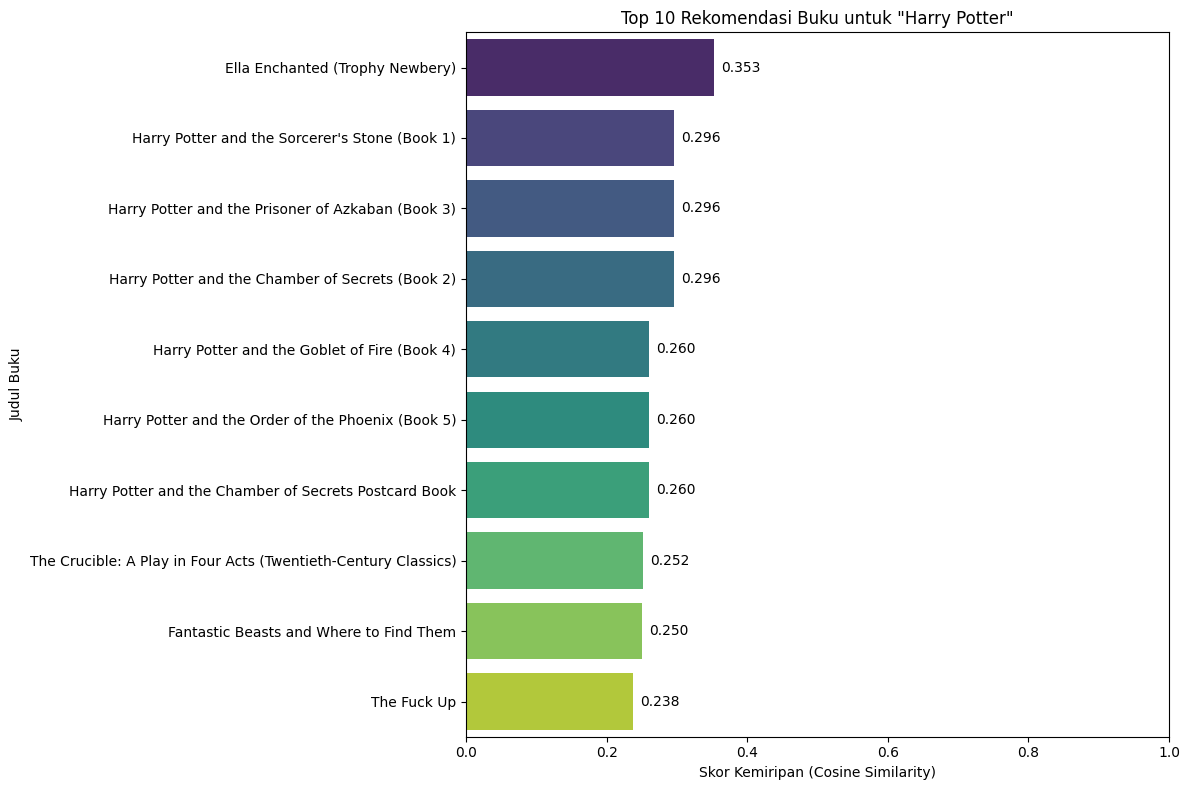

In [ ]:
input_book_title = "Harry Potter"
recommendations_df = get_book_recommendations(input_book_title, num_recommendations=10)

if not recommendations_df.empty:
    recommendations_df = recommendations_df.head(10).copy()
    recommendations_df['index'] = range(len(recommendations_df))

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='similarity_score',
        y='index',
        data=recommendations_df,
        palette='viridis',
        orient='h'
    )

    plt.yticks(ticks=range(len(recommendations_df)), labels=recommendations_df['Book-Title'])

    plt.title(f'Top 10 Rekomendasi Buku untuk "{input_book_title}"')
    plt.xlabel('Skor Kemiripan (Cosine Similarity)')
    plt.ylabel('Judul Buku')
    plt.xlim(0, 1)

    for index, value in enumerate(recommendations_df['similarity_score']):
        plt.text(value + 0.01, index, f'{value:.3f}', va='center')

    plt.tight_layout()
    plt.show()

else:
    print(f"Tidak ada data rekomendasi untuk divisualisasikan untuk buku '{input_book_title}'.")
